# Image Denoising with AutoEncoders

### 1- Importing libraries

In [53]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

In [ ]:
# Loading dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
X_test.shape

(10000, 28, 28)

### 2- Data visualization

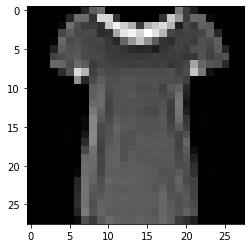

In [6]:
# Let's view a random image
i = random.randint(1,60000) 
plt.imshow( X_train[i] , cmap = 'gray') 

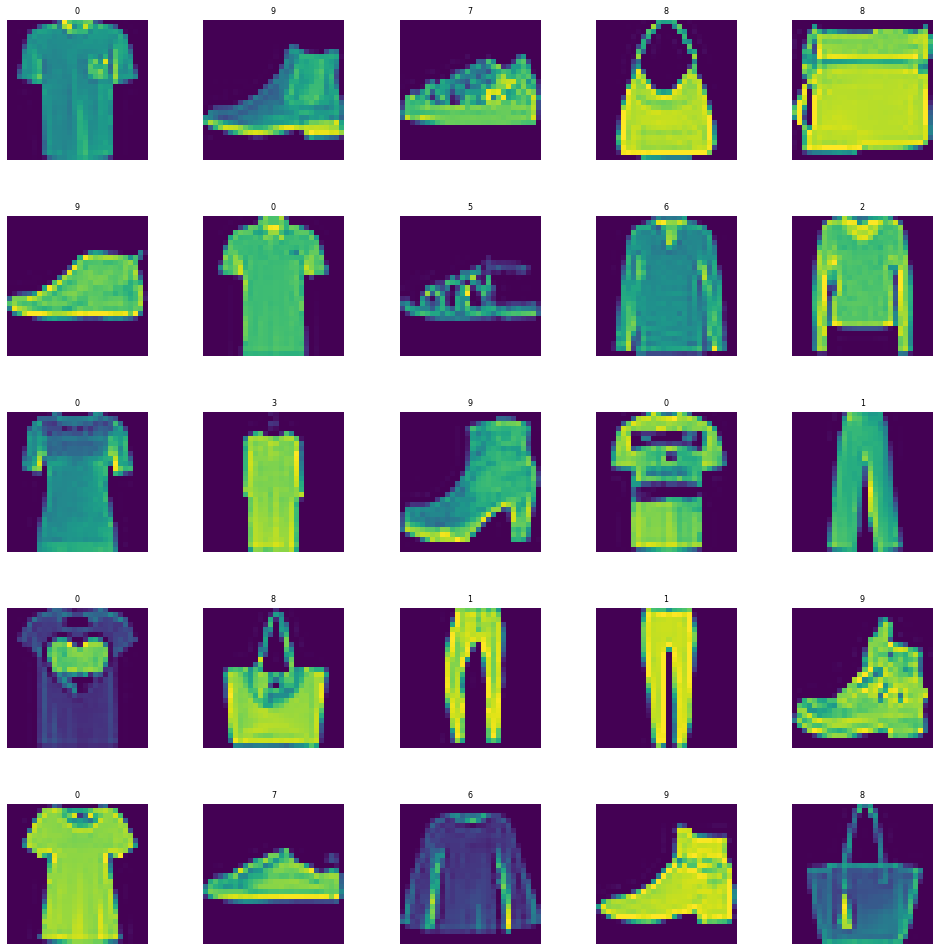

In [8]:
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_training)
    # read and display an image with the selected index    
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


### 3- Data preprocessing

In [9]:
X_train = X_train / 255
X_test = X_test / 255

In [41]:
noise_factor = 0.3
noise_train_set  = np.array([ np.clip( img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape),0.0, 1.0) for img in X_train ])
noise_test_set = np.array([ np.clip( img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape),0.0, 1.0) for img in X_test ])

In [38]:
noise_train_set.shape

(60000, 28, 28)

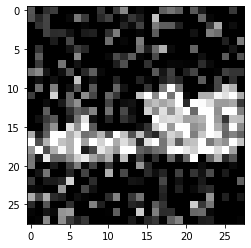

In [42]:
plt.imshow(noise_train_set[random.randint(0,60000)], cmap="gray")

###  4- Building and training autoencoder

In [66]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)

x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0   

In [67]:
history =autoencoder.fit(noise_train_set.reshape(-1, 28, 28, 1),          
                X_train.reshape(-1, 28, 28, 1), 
                epochs=30, 
                batch_size=128,
                shuffle=True,
                validation_data=(noise_test_set.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1)))


Epoch 1/30
469/469 [==============================] - 17s 34ms/step - loss: 0.2973 - val_loss: 0.3298
Epoch 2/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2750 - val_loss: 0.2759
Epoch 3/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2730 - val_loss: 0.2753
Epoch 4/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2720 - val_loss: 0.2738
Epoch 5/30
469/469 [==============================] - 15s 33ms/step - loss: 0.2713 - val_loss: 0.2732
Epoch 6/30
469/469 [==============================] - 15s 33ms/step - loss: 0.2708 - val_loss: 0.2737
Epoch 7/30
469/469 [==============================] - 15s 33ms/step - loss: 0.2704 - val_loss: 0.2725
Epoch 8/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2701 - val_loss: 0.2727
Epoch 9/30
469/469 [==============================] - 15s 33ms/step - loss: 0.2699 - val_loss: 0.2727
Epoch 10/30
469/469 [==============================] - 15s 32ms/step - loss: 0.269

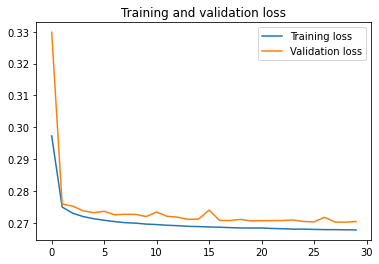

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(30)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 5- Evlaute model

In [70]:
predicted = autoencoder.predict(noise_test_set[:10].reshape(-1, 28, 28, 1))

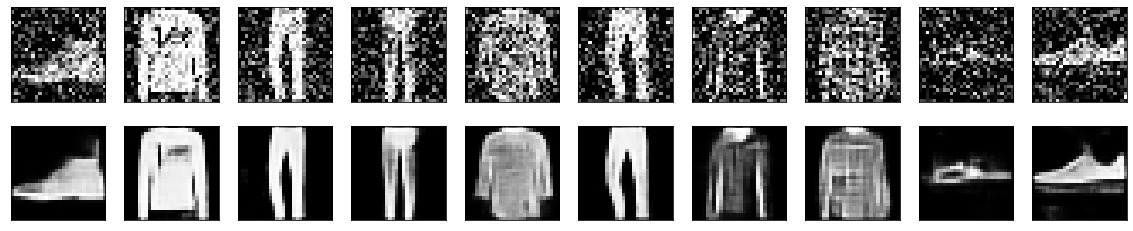

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([noise_test_set[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)